# Data Cleaning

Exclusion critera:
1. Don't use social media
2. Was aware of one of the rumours
2. An outlier in completion time (>3 std devs below the mean)

In [8]:
import pandas as pd
import numpy as np
participants = pd.read_json("../data/raw/mock_data/participant-schema.json",orient="records")
num_participants = len(participants["PROLIFIC_ID"].unique())
dummies = ["gender","affiliatedMovements","socialMedias"]
for col in dummies:
    participants = participants.explode(col)
participants = pd.get_dummies(participants,columns=dummies).max(level=0)
assert len(participants) == num_participants, "Number of participants changed"
num_participants = len(participants["PROLIFIC_ID"].unique())
print(f"Original number of participants: {num_participants}")

Original number of participants: 499


In [9]:
to_drop = pd.Series(None,name="PROLIFIC_ID",dtype=str)

### 1. Drop participants who don't use social media

In [10]:
sm_cols = [c for c in participants.columns if "socialMedias" in c and not "none" in c]
# TODO: when you actually have a none option (which hopefully people won't click as much) uncomment the rest
# of the line
no_sm = (participants[sm_cols] == 0).T.all()#| participants["socialMedias_none"].astype(bool))
no_sm = pd.Series(participants[no_sm]["PROLIFIC_ID"].unique())
to_drop = pd.Series(to_drop.append(no_sm))
num_no_sm = len(no_sm)
num_participants -= num_no_sm
print(f"{num_no_sm} don't have social media, {num_participants} remaining participants.")

50 don't have social media, 449 remaining participants.


### 2. Drop participants who were aware of either rumour

In [11]:
post_study = pd.read_json("../data/raw/mock_data/post-study-schema.json",orient="records")
assert len(post_study) == len(participants), "Dataframes have different row lengths"
aware = post_study["awareR1"].astype(bool) | post_study["awareR2"].astype(bool)
aware = pd.Series(post_study[aware]["PROLIFIC_ID"].unique())
to_drop = pd.Series(to_drop.append(aware))
num_aware = len(aware)
num_participants -= num_aware
print(f"{num_aware} aware of a rumour, {num_participants} remaining participants.")

58 aware of a rumour, 391 remaining participants.


### 2. Drop participants who were outliers in the amount of time taken

Outlier: participants who the amount of time taken is more than 3 standard deviations below the mean 
- not above as we put a time cap on the time taken

In [12]:
posts = pd.read_json("../data/raw/mock_data/posts-schema.json",orient="records")
posts = posts.explode("posts")
posts = pd.concat([posts.drop(['posts'], axis=1), posts['posts'].apply(pd.Series)], axis=1)
assert (posts.groupby("PROLIFIC_ID").count()["id"] == 20).all(), "Some people have a different number of posts"
posts

,id,PROLIFIC_ID,STUDY_ID,SESSION_ID,treatment,secondsTaken,rumour,rumourId,evidence,code,mockGender,timestamp,warning,reshared
0,1,1,1,1,True,93.87,R1,R1-1,high,questions,Female,57,False,True
0,1,1,1,1,True,93.87,R2,R2-1,low,questions,Female,9,False,True
0,1,1,1,1,True,93.87,R1,R1-2,high,affirms,Male,48,False,True
0,1,1,1,1,True,93.87,R2,R2-2,low,affirms,Female,21,True,False
0,1,1,1,1,True,93.87,R1,R1-3,high,affirms,Male,23,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,499,499,1,499,False,93.32,R2,R2-8,low,neutral,Male,43,False,True
498,499,499,1,499,False,93.32,R1,R1-9,high,questions,Male,1,False,True
498,499,499,1,499,False,93.32,R2,R2-9,low,affirms,Female,2,False,False
498,499,499,1,499,False,93.32,R1,R1-10,high,denies,Male,40,False,True


1 outlier(s) in completion time, 389 remaining participants.


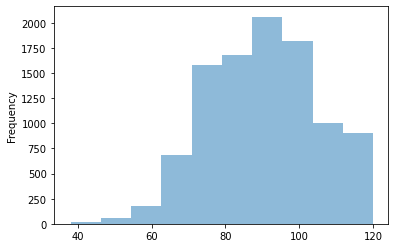

In [13]:
from scipy.stats import zscore
posts.secondsTaken.plot.hist(alpha=0.5)
z_scores = zscore(posts["secondsTaken"])
outliers = posts[z_scores < -3]
outliers.secondsTaken.plot.hist(alpha=0.5)
outliers = pd.Series(outliers["PROLIFIC_ID"].unique())
num_outliers = len(outliers)
to_drop = pd.Series(to_drop.append(outliers))
num_participants -= num_outliers
print(f"{num_outliers} outlier(s) in completion time, {num_participants-num_outliers} remaining participants.")

Write to file

In [14]:
participants = participants[~participants["PROLIFIC_ID"].isin(to_drop)]
posts = posts[~posts["PROLIFIC_ID"].isin(to_drop)]
post_study = post_study[~post_study["PROLIFIC_ID"].isin(to_drop)]

In [8]:
participants.to_csv("../data/processed/mock_data/participant-schema.csv",index=False)
posts.to_csv("../data/processed/mock_data/posts-schema.csv",index=False)
post_study.to_csv("../data/processed/mock_data/post-study-schema.csv",index=False)

## Merge data

1. System level data
2. post level data

### System level data

In [37]:
from collections import OrderedDict
group_cols = ["PROLIFIC_ID","treatment","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['treatment'] = reshare_rates['treatment'].replace({False: 'Control',
                                                                 True: 'Treatment'})
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
reshare_rates = reshare_rates.pivot(index=["PROLIFIC_ID","treatment","evidence"],
                                    columns="code",
                                    values="reshared").reset_index()
cols = list(OrderedDict.fromkeys(list(participants.columns[1:])+list(reshare_rates.columns)))
reshare_rates = reshare_rates.merge(participants,how="left",left_on="PROLIFIC_ID",right_on="PROLIFIC_ID")
reshare_rates = reshare_rates.fillna(0)[cols]

$rumour proportion = \frac{affirms}{affirms + denies}$

In [38]:
rumour_prop_col = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum()).reset_index()
rumour_prop_col = rumour_prop_col.pivot(index=["PROLIFIC_ID","treatment","evidence"],
                                    columns="code",
                                    values="reshared").reset_index().set_index("PROLIFIC_ID")

rumour_prop_col = rumour_prop_col["affirms"] /(rumour_prop_col["affirms"]+rumour_prop_col["denies"])
reshare_rates = reshare_rates.assign(rumour_proportion=rumour_prop_col.values)
reshare_rates.to_csv("../data/processed/mock_data/reshare_rates.csv",index=False)